In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from scipy.stats import zscore

In [69]:
np.random.seed(42)
backend = set_backend("cupy")
plt.style.use("default")
sns.set_theme(style="whitegrid")

In [70]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1, 0, 0]
noise_scalar = 0
hidden_feature_space_names = ["A", "B", "C"]
researcher_feature_space_names = [r"$X_1$", r"$X_2$"]

In [71]:
alphas = np.logspace(-4, 4, 10)
cv = 10

generate random feature spaces

In [72]:
feature_spaces = [zscore(np.random.randn(n_samples_train + n_samples_test, dim)) for dim in d_list]

<Axes: ylabel='Count'>

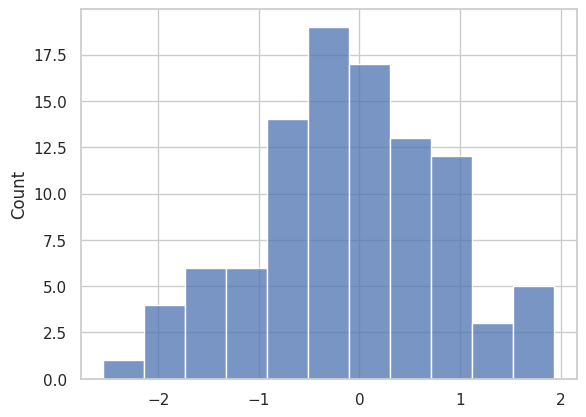

In [73]:
sns.histplot(feature_spaces[0][0])

split feature spaces into train and test samples

In [74]:
feature_spaces_train = [feature_space[:n_samples_train] for feature_space in feature_spaces]
feature_spaces_test = [feature_space[n_samples_train:] for feature_space in feature_spaces]

concatenate the first feature with all other feature spaces
[0, 1], [0, 2], [0, 3], ...

In [75]:
Xs_train = [np.hstack([feature_spaces_train[0], feature_space]) for feature_space in feature_spaces_train[1:]]
Xs_test = [np.hstack([feature_spaces_test[0], feature_space]) for feature_space in feature_spaces_test[1:]]

In [76]:
Xs_train = [zscore(x) for x in Xs_train]
Xs_test = [zscore(x) for x in Xs_test]

generate weights

In [77]:
betas = [np.random.randn(d, n_targets) for d in d_list]

In [78]:
betas = [zscore(beta, axis=0) for beta in betas]

create targets

In [79]:
Y_train = sum(
    [alpha * feature_space @ beta for alpha, feature_space, beta in
     zip(scalars, feature_spaces_train, betas)])
Y_test = sum(
    [alpha * feature_space @ beta for alpha, feature_space, beta in
     zip(scalars, feature_spaces_test, betas)])

In [80]:
Y_train = zscore(Y_train)
Y_test = zscore(Y_test)

add noise

In [81]:
noise_train = zscore(np.random.randn(n_samples_train, n_targets))
noise_test = zscore(np.random.randn(n_samples_test, n_targets))

In [82]:
Y_train += noise_train * noise_scalar
Y_test += noise_test * noise_scalar

Plot simple linear model

In [83]:
hidden_feature_space = 0

feature = 50
target = 50
X = feature_spaces_train[hidden_feature_space][:, feature]
X.shape


(1000,)

In [84]:
Y = Y_train[:, target]
Y.shape

(1000,)

In [85]:
data = pd.DataFrame(
    {
        "X": X,
        "Y": Y,
    }
)
data

,X,Y
0,0.291644,0.710264
1,0.220597,-0.214184
2,-1.238526,0.089770
3,0.278923,-0.779543
4,-0.081747,0.022882
...,...,...
995,1.222821,-0.823238
996,0.226786,0.143328
997,-0.582155,-1.014108
998,-1.494166,-0.180752


In [86]:
true_slope = betas[hidden_feature_space][feature][target]
true_slope

np.float64(1.5023088755515837)

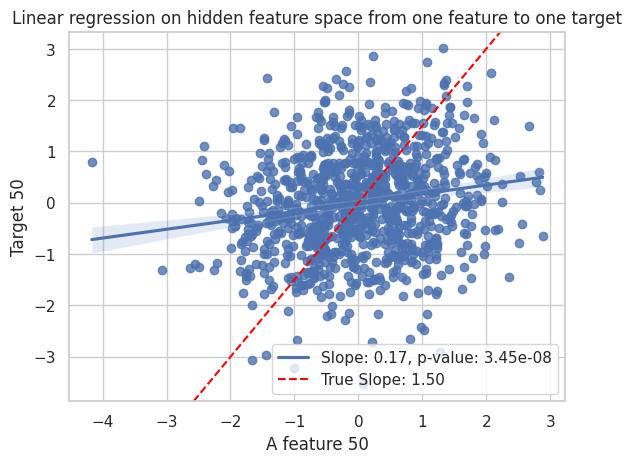

In [87]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(data["X"], data["Y"])
sns.regplot(data, x="X", y="Y", line_kws={"label": f"Slope: {slope:.2f}, p-value: {p_value:.2e}"})
# Add a red dashed line for the true slope
plt.axline((0, 0), slope=true_slope, color='red', linestyle='--',
           label=f"True Slope: {true_slope:.2f}")
plt.title("Linear regression on hidden feature space from one feature to one target")
plt.xlabel(f"{hidden_feature_space_names[hidden_feature_space]} feature {feature}")
plt.ylabel(f"Target {target}")
plt.legend()

train simple linear models to confirm feature spaces predict the target

In [88]:
scores = pd.DataFrame()

linear_models = [RidgeCV(alphas=alphas, cv=cv) for _ in range(len(feature_spaces_train))]
for i, model in enumerate(linear_models):
    model.fit(feature_spaces_train[i], Y_train)
    score = model.score(feature_spaces_test[i], Y_test)
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [hidden_feature_space_names[i]], 'Score': [backend.to_numpy(score).mean()],
                      'EV': [scalars[i]]})], ignore_index=True
    )
scores

,feature space,Score,EV
0,A,0.984549,1
1,B,-0.001487,0
2,C,-0.002092,0


Text(0.5, 1.0, 'RidgeCV hidden feature scores')

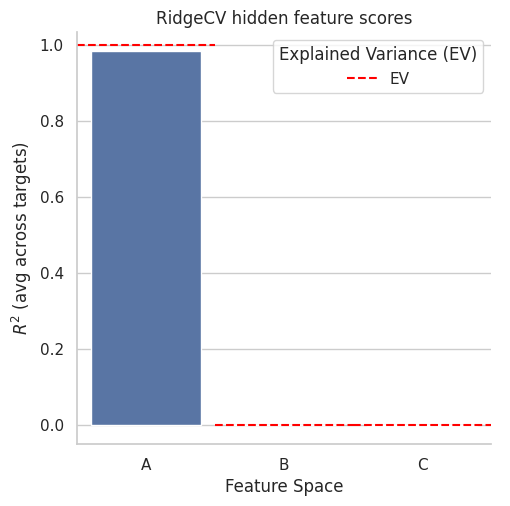

In [89]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space",
                                                                                     r"$R^2$ (avg across targets)")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Explained Variance (EV)")
plt.title("RidgeCV hidden feature scores")

now train on researcher side feature spaces

In [90]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV(alphas=alphas, cv=cv) for _ in range(len(Xs_train))]
for i, model in enumerate(linear_models):
    model.fit(Xs_train[i], Y_train)
    score = model.score(Xs_test[i], Y_test)
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'feature space': [researcher_feature_space_names[i]], 'Score': [backend.to_numpy(score).mean()],
                      'EV': scalars[0] + scalars[i + 1]})],
        ignore_index=True
    )
researcher_scores

,feature space,Score,EV
0,$X_1$,0.990248,1
1,$X_2$,0.990248,1


Text(0.5, 1.0, 'Researcher side feature space scores')

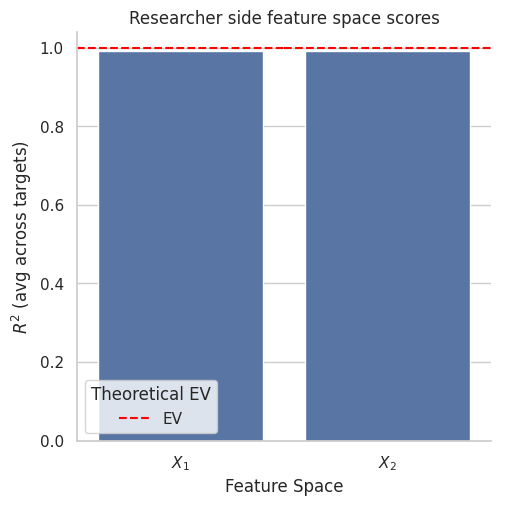

In [91]:
plot = sns.catplot(researcher_scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space",
                                                                                                r"$R^2$ (avg across targets)")
for index, row in researcher_scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 2, xmax=(index + 1) / 2,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Theoretical EV")
plt.title("Researcher side feature space scores")